## DATA-698 Capstone Project, Spring 2017
### Author: Mohamed Elmoudni


### Background

Nearly half of the world depends on seafood for their main source of protein. In the Western and Central
Pacific, where 60% of the world’s tuna is caught, illegal, unreported, and unregulated fishing practices are
threatening marine ecosystems, global seafood supplies and local livelihoods. The Nature Conservancy is
working with local, regional and global partners to preserve this fishery for the future.
The Nature Conservancy pioneers new technology and data analytics solutions to collect baseline scientific
data on fishery health, monitor fleet compliance with fishery regulations and deliver “bait to plate” traceability
to seafood suppliers and consumers. In WCPO longline tuna fisheries, the Conservancy is deploying electronic
monitoring systems on longline vessels to improve scientific data collection and reduce poaching.
Project Overview
In this project, we will be training a deep learning model to automatically detect and classify species of tunas,
sharks and more that fishing boats catch, which will accelerate the recording review process. The approach is
to have an algorithm embedded into a fully automated software tool that workers could use in their fishing
operations. The algorithm will help fishermen detect which species of fish appears on a fishing boat, based on
images captured from boat cameras of various angles.

### Approach

In this project, we are going to train a machine learning model to predict the likelihood of fish species
in each picture. Eight target categories are available in this dataset: Albacore tuna, Bigeye tuna,
Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other (meaning that there are fish present but not in
the above categories), and No Fish (meaning that no fish is in the picture). Each image has only
one fish category, except that there are sometimes very small fish in the pictures that are used as
bait. We’ll first create a synthetic dataset and use that to train our model. We’ll then validate the
model synthetic test data. We will create multiple models using grid search for epochs, batch size,
and optimizer. Below is a sample of fish images (categories) we will be looking for in the fish boats:

### Data Acquisition

The dataset was compiled by The Nature Conservancy in partnership with Satlink, Archipelago Marine
Research, the Pacific Community, the Solomon Islands Ministry of Fisheries and Marine Resources, the
Australia Fisheries Management Authority, and the governments of New Caledonia and Palau.
The train and test datasets is downloaded locally from Kaggle website. Then, the data is uploaded into Docker
container. The train data is then loaded into the /DATA/TRAIN/ folder. It will be stored accordingly:
Albacore tuna: /DATA/TRAIN/ALB/
    
Bigeye tuna:/DATA/TRAIN/BET/
    
Mahi Mahi:/DATA/TRAIN/DOL/
    
Opah: /DATA/TRAIN/LAG/
    
Sharks: /DATA/TRAIN/SHARK/
    
Yellowfin tuna: /DATA/TRAIN/YFT/
    
Other fish than the above: /DATA/TRAIN/OTHER/
    
No fish in the picture: /DATA/TRAIN/Nof/
    
The test data is loaded in /DATA/TEST/

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K

# image proccesssing 
from PIL import Image
from StringIO import StringIO
import requests
import numpy as np
import PIL
from resizeimage import resizeimage

Using Theano backend.


In [2]:
TRAIN_DIR = '/DATA/TRAIN/'
TEST_DIR = '/DATA/TEST/'


FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'Nof', 'OTHER', 'SHARK', 'YFT']
ROWS = 90  #720
COLS = 160 #1280
CHANNELS = 3

In [3]:
%matplotlib inline
def get_images(fish):
    """Load files from train folder"""
    fish_dir = TRAIN_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    return im


files = []
y_all = []
results = []

for fish in FISH_CLASSES:
    fish_files = get_images(fish)
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    y_all.extend(y_fish)
    print("{0} photos of {1}".format(len(fish_files), fish))
    hist = np.histogram(len(fish_files))
    plt.hist
    plt.show()
    #print len(fish_files)
    results.append(len(fish_files))
    
    
y_all = np.array(y_all)
print results
hist = np.histogram(results)
plt.hist
plt.show()

1719 photos of ALB
200 photos of BET
117 photos of DOL
67 photos of LAG
465 photos of Nof
299 photos of OTHER
176 photos of SHARK
734 photos of YFT
[1719, 200, 117, 67, 465, 299, 176, 734]


### Data Exploration

[1719, 200, 117, 67, 465, 299, 176, 734]
['ALB', 'BET', 'DOL', 'LAG', 'Nof', 'OTHER', 'SHARK', 'YFT']


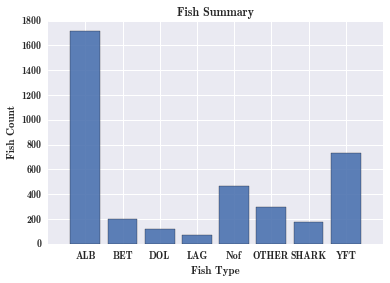

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#x = np.random.normal(size = 1000)
print results
print FISH_CLASSES
#plt.hist(results, orientation=u'horizontal')
#plt.xticks(results , FISH_CLASSES)
#plt.gca().invert_xaxis()
y_pos = np.arange(len(FISH_CLASSES))
plt.bar(y_pos, results, align='center', alpha=0.9)
plt.xticks(y_pos, FISH_CLASSES)
plt.ylabel('Fish Count')
plt.xlabel('Fish Type')
plt.title('Fish Summary')

In [6]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(files): 
    X_all[i] = read_image(TRAIN_DIR+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 3777
Processed 1000 of 3777
Processed 2000 of 3777
Processed 3000 of 3777
(3777, 90, 160, 3)


In [7]:
# One Hot Encoding Labels
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=y_all)

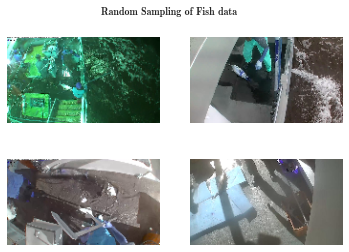

In [28]:
%matplotlib inline
import struct
from numpy import *
from matplotlib.pyplot import *

# Get the figure and axes.
fig, axes = subplots(2, 2)
axes = axes.reshape(4)
fig.suptitle("Random Sampling of Fish data")

# Plot random images.
indices = random.randint(len(X_train), size=4)
for axis, index in zip(axes, indices):
    image = X_train[index, :, :]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.imshow(image,cmap = cm.Greys_r)

### Model creation
I will be creating three Convolution Neural Network (CNN) models with different topologies and different
hyper parameters. In addition I will apply augmentation techniques on the best performing model.

In [11]:
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(60, 5, 5, border_mode='same', activation='relu'))
#model.add(Convolution2D(10, 5, 5, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(12, 3, 3, border_mode='same', activation='relu'))
#model.add(Convolution2D(6, 3, 3, border_mode='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
#model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
#model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

#model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
#model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
#model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(FISH_CLASSES)))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss=objective, optimizer=optimizer)

In [29]:
def create_model(optimizer='rmsprop', init='glorot_uniform'):
   model = Sequential()
   model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))
   model.add(Convolution2D(60, 5, 5, border_mode='same', activation='relu'))
   #model.add(Convolution2D(12, 5, 5, border_mode='same', activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Convolution2D(12, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(6, 3, 3, border_mode='same', activation='relu'))
   #model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
   #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
   model.add(Flatten())
   model.add(Dense(128, activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(50, activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(len(FISH_CLASSES)))
   model.add(Activation('sigmoid'))
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   #model.compile(loss=objective, optimizer=optimizer)
   return model

In [30]:
# start timing 
model = create_model(optimizer='rmsprop', init='glorot_uniform')
def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)
#model = cnn_model()
import timeit
start_time = timeit.default_timer()

X_test =  X_valid
y_test = y_valid

# build the model
#model = cnn_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=32, batch_size=32,
verbose=2)
# Final evaluationof the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Small CNN Model One Error: %.2f%%" % (100-scores[1]*100))

#ending time
elapsed = timeit.default_timer() - start_time
print ("Time Elapsed :",elapsed)

Train on 3021 samples, validate on 756 samples
Epoch 1/32
80s - loss: 1.7354 - acc: 0.3701 - val_loss: 1.4336 - val_acc: 0.4841
Epoch 2/32
79s - loss: 1.4888 - acc: 0.4641 - val_loss: 1.1367 - val_acc: 0.5185
Epoch 3/32
80s - loss: 1.2628 - acc: 0.5220 - val_loss: 0.9977 - val_acc: 0.6362
Epoch 4/32
79s - loss: 1.0869 - acc: 0.5849 - val_loss: 0.7763 - val_acc: 0.6825
Epoch 5/32
80s - loss: 0.9284 - acc: 0.6461 - val_loss: 0.6595 - val_acc: 0.7196
Epoch 6/32
81s - loss: 0.8187 - acc: 0.7027 - val_loss: 0.5529 - val_acc: 0.8108
Epoch 7/32
80s - loss: 0.6833 - acc: 0.7640 - val_loss: 0.4509 - val_acc: 0.8373
Epoch 8/32
82s - loss: 0.5968 - acc: 0.8037 - val_loss: 0.4457 - val_acc: 0.8571
Epoch 9/32
83s - loss: 0.4975 - acc: 0.8272 - val_loss: 0.3393 - val_acc: 0.8981
Epoch 10/32
91s - loss: 0.4297 - acc: 0.8587 - val_loss: 0.2939 - val_acc: 0.8995
Epoch 11/32
79s - loss: 0.4033 - acc: 0.8716 - val_loss: 0.3061 - val_acc: 0.8981
Epoch 12/32
80s - loss: 0.3134 - acc: 0.8971 - val_loss: 0.2

In [31]:
hist = model.fit(X_test, y_test,nb_epoch=32, validation_split=0.2)

Train on 604 samples, validate on 152 samples
Epoch 1/32
604/604 [==============================] - 16s - loss: 0.3308 - acc: 0.9454 - val_loss: 0.0717 - val_acc: 0.9737
Epoch 2/32
604/604 [==============================] - 16s - loss: 0.2011 - acc: 0.9470 - val_loss: 0.2019 - val_acc: 0.9671
Epoch 3/32
604/604 [==============================] - 15s - loss: 0.1803 - acc: 0.9487 - val_loss: 0.1197 - val_acc: 0.9671
Epoch 4/32
604/604 [==============================] - 15s - loss: 0.1722 - acc: 0.9503 - val_loss: 0.1408 - val_acc: 0.9671
Epoch 5/32
604/604 [==============================] - 16s - loss: 0.1639 - acc: 0.9586 - val_loss: 0.1073 - val_acc: 0.9671
Epoch 6/32
604/604 [==============================] - 16s - loss: 0.1101 - acc: 0.9719 - val_loss: 0.0809 - val_acc: 0.9671
Epoch 7/32
604/604 [==============================] - 15s - loss: 0.0691 - acc: 0.9834 - val_loss: 0.0676 - val_acc: 0.9803
Epoch 8/32
604/604 [==============================] - 15s - loss: 0.0598 - acc: 0.9801

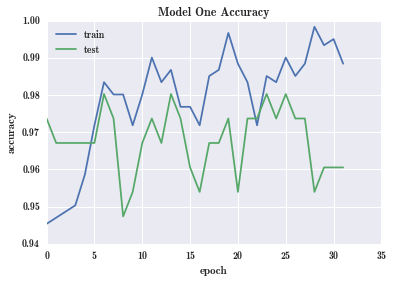

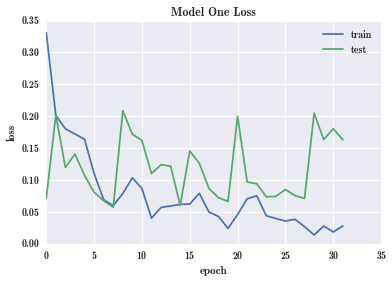

In [32]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model One Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model One Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [34]:
def create_model2(optimizer='rmsprop', init='glorot_uniform'):
   model = Sequential()
   model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

   #model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
   model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(MaxPooling2D(pool_size=(2, 2)))


   model.add(Flatten())
   model.add(Dense(64, activation='relu'))
   model.add(Dropout(0.5))

   model.add(Dense(64, activation='relu'))
   model.add(Dropout(0.5))

   model.add(Dense(len(FISH_CLASSES)))
   model.add(Activation('sigmoid'))
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   #model.compile(loss=objective, optimizer=optimizer)
   return model

In [35]:
# start timing 
model = create_model2(optimizer='rmsprop', init='glorot_uniform')
def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)
#model = cnn_model()
import timeit
start_time = timeit.default_timer()

X_test =  X_valid
y_test = y_valid

# build the model
#model = cnn_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=32, batch_size=32,
verbose=2)
# Final evaluationof the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Medium CNN Model Two Error: %.2f%%" % (100-scores[1]*100))

#ending time
elapsed = timeit.default_timer() - start_time
print ("Time Elapsed :",elapsed)

Train on 3021 samples, validate on 756 samples
Epoch 1/32
118s - loss: 1.8545 - acc: 0.3691 - val_loss: 1.5755 - val_acc: 0.4616
Epoch 2/32
116s - loss: 1.6613 - acc: 0.4373 - val_loss: 1.4404 - val_acc: 0.4616
Epoch 3/32
117s - loss: 1.5467 - acc: 0.4465 - val_loss: 1.3051 - val_acc: 0.4616
Epoch 4/32
117s - loss: 1.4063 - acc: 0.4628 - val_loss: 1.1289 - val_acc: 0.5106
Epoch 5/32
117s - loss: 1.2571 - acc: 0.4906 - val_loss: 0.9973 - val_acc: 0.5754
Epoch 6/32
117s - loss: 1.1602 - acc: 0.5475 - val_loss: 0.8730 - val_acc: 0.6071
Epoch 7/32
117s - loss: 1.0298 - acc: 0.6015 - val_loss: 0.7387 - val_acc: 0.7368
Epoch 8/32
117s - loss: 0.8865 - acc: 0.6647 - val_loss: 0.6014 - val_acc: 0.7738
Epoch 9/32
118s - loss: 0.8003 - acc: 0.6978 - val_loss: 0.5600 - val_acc: 0.7963
Epoch 10/32
118s - loss: 0.7583 - acc: 0.7130 - val_loss: 0.5160 - val_acc: 0.8228
Epoch 11/32
118s - loss: 0.7137 - acc: 0.7266 - val_loss: 0.4722 - val_acc: 0.8320
Epoch 12/32
118s - loss: 0.6250 - acc: 0.7633 - v

In [36]:
hist = model.fit(X_test, y_test,nb_epoch=32, validation_split=0.2)

Train on 604 samples, validate on 152 samples
Epoch 1/32
604/604 [==============================] - 24s - loss: 0.5665 - acc: 0.8096 - val_loss: 0.2667 - val_acc: 0.8750
Epoch 2/32
604/604 [==============================] - 24s - loss: 0.4764 - acc: 0.8394 - val_loss: 0.3248 - val_acc: 0.8750
Epoch 3/32
604/604 [==============================] - 23s - loss: 0.4311 - acc: 0.8477 - val_loss: 0.2536 - val_acc: 0.8882
Epoch 4/32
604/604 [==============================] - 24s - loss: 0.4340 - acc: 0.8394 - val_loss: 0.2024 - val_acc: 0.9013
Epoch 5/32
604/604 [==============================] - 23s - loss: 0.3894 - acc: 0.8510 - val_loss: 0.2857 - val_acc: 0.9013
Epoch 6/32
604/604 [==============================] - 23s - loss: 0.4075 - acc: 0.8444 - val_loss: 0.2229 - val_acc: 0.8947
Epoch 7/32
604/604 [==============================] - 25s - loss: 0.3447 - acc: 0.8725 - val_loss: 0.2295 - val_acc: 0.9211
Epoch 8/32
604/604 [==============================] - 24s - loss: 0.3543 - acc: 0.8758

['acc', 'loss', 'val_acc', 'val_loss']


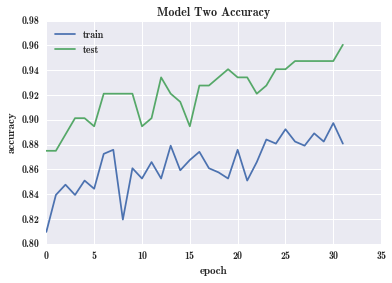

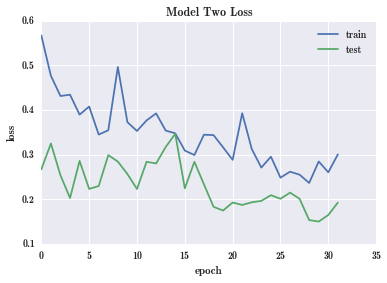

In [37]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Two Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Two Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
def create_model3(optimizer='rmsprop', init='glorot_uniform'):
   model = Sequential()
   model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

   #model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
   model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(MaxPooling2D(pool_size=(2, 2)))


   model.add(Flatten())
   model.add(Dense(128, activation='relu'))
   model.add(Dropout(0.5))

   model.add(Dense(128, activation='relu'))
   model.add(Dropout(0.5))

   model.add(Dense(len(FISH_CLASSES)))
   model.add(Activation('sigmoid'))
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   #model.compile(loss=objective, optimizer=optimizer)
   return model

In [13]:
# start timing 
model = create_model3(optimizer='rmsprop', init='glorot_uniform')
def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)
#model = cnn_model()
import timeit
start_time = timeit.default_timer()

X_test =  X_valid
y_test = y_valid

# build the model
#model = cnn_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=32, batch_size=32,
verbose=2)
# Final evaluationof the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN,Model 3  Error: %.2f%%" % (100-scores[1]*100))

#ending time
elapsed = timeit.default_timer() - start_time
print ("Time Elapsed :",elapsed)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 3021 samples, validate on 756 samples
Epoch 1/32
335s - loss: 1.8144 - acc: 0.3790 - val_loss: 1.5402 - val_acc: 0.4616
Epoch 2/32
303s - loss: 1.5626 - acc: 0.4482 - val_loss: 1.3456 - val_acc: 0.4696
Epoch 3/32
286s - loss: 1.3614 - acc: 0.4624 - val_loss: 1.0626 - val_acc: 0.4775
Epoch 4/32
283s - loss: 1.1546 - acc: 0.5263 - val_loss: 0.9210 - val_acc: 0.6376
Epoch 5/32
283s - loss: 0.9284 - acc: 0.6544 - val_loss: 0.6266 - val_acc: 0.7474
Epoch 6/32
299s - loss: 0.7514 - acc: 0.7306 - val_loss: 0.4646 - val_acc: 0.8214
Epoch 7/32
283s - loss: 0.6247 - acc: 0.7848 - val_loss: 0.3744 - val_acc: 0.8585
Epoch 8/32
281s - loss: 0.4700 - acc: 0.8315 - val_loss: 0.2950 - val_acc: 0.8942
Epoch 9/32
299s - loss: 0.4008 - acc: 0.8580 - val_loss: 0.2357 - val_acc: 0.9272
Epoch 10/32
303s - loss: 0.3320 - acc: 0.8835 - val_loss: 0.2565 - val_acc: 0.9299
Epoch 11/32
299s - loss: 0.2898 - acc: 0.8990 - val_loss: 0.2623 - val_acc: 0.9167
Epoch 12/32
284s - loss: 0.2378 - acc: 0.9159 - v

In [54]:
hist = model.fit(X_test, y_test,nb_epoch=32, validation_split=0.2)

Train on 604 samples, validate on 152 samples
Epoch 1/32
604/604 [==============================] - 63s - loss: 0.4466 - acc: 0.8675 - val_loss: 0.2580 - val_acc: 0.9276
Epoch 2/32
604/604 [==============================] - 62s - loss: 0.3599 - acc: 0.8642 - val_loss: 0.2577 - val_acc: 0.9474
Epoch 3/32
604/604 [==============================] - 63s - loss: 0.3525 - acc: 0.8825 - val_loss: 0.2324 - val_acc: 0.9211
Epoch 4/32
604/604 [==============================] - 62s - loss: 0.3678 - acc: 0.8825 - val_loss: 0.2192 - val_acc: 0.9539
Epoch 5/32
604/604 [==============================] - 62s - loss: 0.2651 - acc: 0.8974 - val_loss: 0.2902 - val_acc: 0.9408
Epoch 6/32
604/604 [==============================] - 62s - loss: 0.3243 - acc: 0.8874 - val_loss: 0.2907 - val_acc: 0.9211
Epoch 7/32
604/604 [==============================] - 62s - loss: 0.2807 - acc: 0.9073 - val_loss: 0.2753 - val_acc: 0.9408
Epoch 8/32
604/604 [==============================] - 63s - loss: 0.2409 - acc: 0.9272

['acc', 'loss', 'val_acc', 'val_loss']


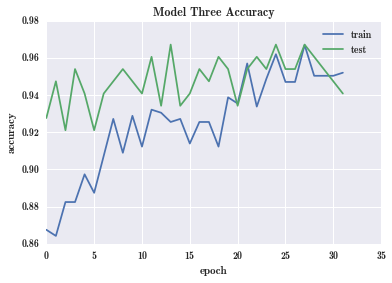

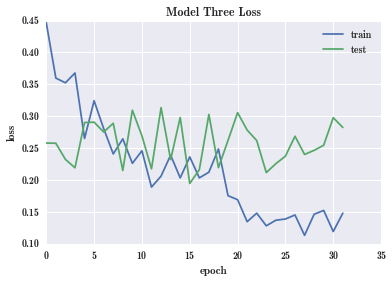

In [55]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Three Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Three Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [41]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import requests
##
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
#dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X, Y = X_train, y_train 
#X = dataset[:,0:8]
#Y = dataset[:,8]
# create model
model = KerasClassifier(build_fn=create_model2, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = numpy.array([10, 10, 10])
batches = numpy.array([8, 16, 32])
param_grid = dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches, init = init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.806024 using {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.749090 (0.061757) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.773916 (0.031843) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 8}
0.806024 (0.023181) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.705727 (0.031365) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 8}
0.766303 (0.013133) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.759682 (0.063306) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 8}
0.768951 (0.054611) with: {'init': 'normal', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.724926 (0.061167) with: {'init': 'normal', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 8}
0.751738 (0.064926) with: {'init': 'normal'

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [38]:
def create_model3(optimizer='rmsprop', init='glorot_uniform'):
   model = Sequential()
   model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

   #model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu'))
   model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(MaxPooling2D(pool_size=(2, 2)))


   model.add(Flatten())
   model.add(Dense(128, activation='relu'))
   model.add(Dropout(0.5))

   model.add(Dense(128, activation='relu'))
   model.add(Dropout(0.5))

   model.add(Dense(len(FISH_CLASSES)))
   model.add(Activation('sigmoid'))
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   #model.compile(loss=objective, optimizer=optimizer)
   return model

In [39]:
def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)
model = create_model3(optimizer='rmsprop', init='glorot_uniform')

In [40]:
from keras.preprocessing.image import ImageDataGenerator
# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

####  trains the neural network using the transformed images;
#np.expand_dims(Y_train, -1)
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    samples_per_epoch=len(X_train), nb_epoch=32)

Epoch 1/32
3021/3021 [==============================] - 269s - loss: 1.8534 - acc: 0.3621   
Epoch 2/32
3021/3021 [==============================] - 272s - loss: 1.6562 - acc: 0.4455   
Epoch 3/32
3021/3021 [==============================] - 266s - loss: 1.5558 - acc: 0.4492   
Epoch 4/32
3021/3021 [==============================] - 265s - loss: 1.4527 - acc: 0.4631   
Epoch 5/32
3021/3021 [==============================] - 264s - loss: 1.3346 - acc: 0.4704   
Epoch 6/32
3021/3021 [==============================] - 260s - loss: 1.2932 - acc: 0.5008   
Epoch 7/32
3021/3021 [==============================] - 264s - loss: 1.1570 - acc: 0.5402   
Epoch 8/32
3021/3021 [==============================] - 264s - loss: 1.0949 - acc: 0.5753   
Epoch 9/32
3021/3021 [==============================] - 269s - loss: 1.0247 - acc: 0.6111   
Epoch 10/32
3021/3021 [==============================] - 268s - loss: 0.9139 - acc: 0.6630   
Epoch 11/32
3021/3021 [==============================] - 268s - loss:

['acc', 'loss', 'val_acc', 'val_loss']


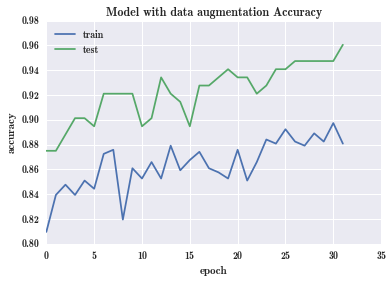

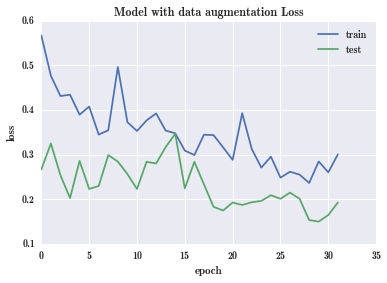

In [41]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model with data augmentation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model with data augmentation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

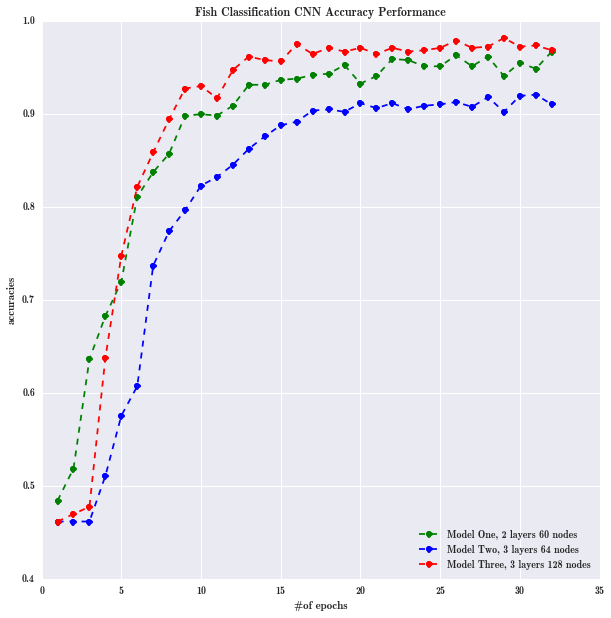

In [65]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger

accuracy1 = [0.4841,0.5185, 0.6362,0.6825,0.7196,0.8108,0.8373,0.8571,0.8981,0.8995,0.8981,0.9087,0.9312,0.9312,0.9365,
0.9378,0.9418,0.9431,0.9524,0.9325,0.9405,0.9590,0.9577,0.9511,0.9511,0.9630,0.9511,0.9616,0.9405,0.9550,
0.9484,0.9669]
epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
#######
#Testing the model using epoch=10 and batch_size=200:
accuracy2 = [0.4616,0.4616,0.4616,0.5106,0.5754,0.6071,0.7368,0.7738,0.7963,0.8228,0.8320,0.8452,0.8624,0.8757,0.8876,0.8915,0.9034
,0.9048,0.9021,0.9114,0.9061,0.9114,0.9048,0.9087,0.9101,0.9127, 0.9074,0.9180,0.9021,0.9193,0.9206,0.9101]
############
accuracy3 = [0.4616, 0.4696, 0.4775,0.6376,0.7474,0.8214,0.8585,0.8942,0.9272,0.9299,0.9167,0.9471, 0.9616,0.9577,0.9563,0.9749,
0.9643,0.9709,0.9669,0.9709,0.9643,0.9709,0.9669,0.9683,0.9709,0.9788,0.9709,0.9722,0.9815, 0.9722,0.9735,0.9683]

#Error1 = [0.9667, 0.9667, 0.9667, 0.9667, 0.9667, 0.9667, 0.9667, 0.9667, 0.9667, 0.9667]
#Error2 = [0.5167,0.5167,0.5167,0.5167,0.5167,0.5167,0.5167,0.5167,0.5167,0.5167]
#plt.plot(epoch, epoch)
plt.plot(epoch, accuracy1, marker='o', linestyle='--', color='g', label='Model 1, lr=.1')
plt.plot(epoch, accuracy2, marker='o', linestyle='--', color='b', label='Model 2, lr=.00001')
plt.plot(epoch, accuracy3, marker='o', linestyle='--', color='r', label='Model 3, lr=.00001')

#plt.plot(epoch, Error1, marker='o', linestyle='--', color='g', label='Model 1, lr=.1')
#plt.plot(epoch, Error2, marker='o', linestyle='--', color='b', label='Model 2, lr=.00001')
#plt.plot(epoch, Error2, marker='o', linestyle='--', color='r', label='Model 3, lr=.00001')

#plt.plot(epoch, accuracy3, marker='o', linestyle='--', color='r', label='accuracy3')
plt.xlabel('#of epochs')
plt.ylabel('accuracies')
plt.title('Fish Classification CNN Accuracy Performance')

plt.legend(['Model One, 2 layers 60 nodes', 'Model Two, 3 layers 64 nodes', 'Model Three, 3 layers 128 nodes'], loc='lower right')

plt.show()

In [16]:
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

def create_model(optimizer='rmsprop', init='glorot_uniform'):
   model = Sequential()
   model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))
   model.add(Convolution2D(60, 5, 5, border_mode='same', activation='relu'))
   #model.add(Convolution2D(12, 5, 5, border_mode='same', activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Convolution2D(6, 3, 3, border_mode='same', activation='relu'))
   #model.add(Convolution2D(6, 3, 3, border_mode='same', activation='relu'))
   #model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
   #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
   #model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))
   model.add(Flatten())
   model.add(Dense(128, activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(50, activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(len(FISH_CLASSES)))
   model.add(Activation('sigmoid'))
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   #model.compile(loss=objective, optimizer=optimizer)
   return model

In [17]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import requests
##
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
#dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X, Y = X_train, y_train 
#X = dataset[:,0:8]
#Y = dataset[:,8]
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = numpy.array([10, 10, 10])
batches = numpy.array([8, 16, 32])
param_grid = dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches, init = init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.842105 using {'init': 'uniform', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 16}
0.833499 (0.018064) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.811652 (0.020709) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 8}
0.802714 (0.018245) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.805362 (0.013543) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 8}
0.783515 (0.029268) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.796425 (0.041240) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 8}
0.798742 (0.022017) with: {'init': 'normal', 'optimizer': 'rmsprop', 'nb_epoch': 10, 'batch_size': 8}
0.826548 (0.019465) with: {'init': 'normal', 'optimizer': 'adam', 'nb_epoch': 10, 'batch_size': 8}
0.817610 (0.032192) with: {'init': 'normal', 'optimi

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [15]:
# start timing 
def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)
#model = cnn_model()
import timeit
start_time = timeit.default_timer()

X_test =  X_valid
y_test = y_valid

# build the model
#model = cnn_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=32,
verbose=2)
# Final evaluationof the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

#ending time
elapsed = timeit.default_timer() - start_time
print ("Time Elapsed :",elapsed)

Train on 3021 samples, validate on 756 samples
Epoch 1/10
2817s - loss: 1.7686 - acc: 0.3757 - val_loss: 1.4523 - val_acc: 0.4934
Epoch 2/10
2925s - loss: 1.4897 - acc: 0.4743 - val_loss: 1.2087 - val_acc: 0.5146
Epoch 3/10
2675s - loss: 1.3217 - acc: 0.5257 - val_loss: 1.0269 - val_acc: 0.6005
Epoch 4/10
1697s - loss: 1.1555 - acc: 0.5690 - val_loss: 0.8593 - val_acc: 0.6746
Epoch 5/10
1844s - loss: 0.9782 - acc: 0.6435 - val_loss: 0.6928 - val_acc: 0.7341
Epoch 6/10
3003s - loss: 0.8502 - acc: 0.6981 - val_loss: 0.5869 - val_acc: 0.8241
Epoch 7/10
2857s - loss: 0.7096 - acc: 0.7567 - val_loss: 0.4872 - val_acc: 0.8519
Epoch 8/10
2680s - loss: 0.6164 - acc: 0.7944 - val_loss: 0.4946 - val_acc: 0.8532
Epoch 9/10
2551s - loss: 0.5142 - acc: 0.8272 - val_loss: 0.3470 - val_acc: 0.9220
Epoch 10/10
1550s - loss: 0.4183 - acc: 0.8603 - val_loss: 0.3588 - val_acc: 0.9008
Large CNN Error: 9.92%
('Time Elapsed :', 24645.627778053284)


In [6]:
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(30, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(30, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(15, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(15, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

#model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
#model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
#model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

#model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
#model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
#model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(FISH_CLASSES)))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer)

In [42]:
def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)
model = create_model3(optimizer='rmsprop', init='glorot_uniform')

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
model.fit(X_train, y_train, batch_size=64, nb_epoch=32,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 2416 samples, validate on 605 samples
Epoch 1/32
2416/2416 [==============================] - 214s - loss: 1.8761 - acc: 0.3700 - val_loss: 1.6255 - val_acc: 0.4380
Epoch 2/32
2416/2416 [==============================] - 214s - loss: 1.6406 - acc: 0.4342 - val_loss: 1.5107 - val_acc: 0.4380
Epoch 3/32
2416/2416 [==============================] - 242s - loss: 1.5048 - acc: 0.4499 - val_loss: 1.3454 - val_acc: 0.4380
Epoch 4/32
2416/2416 [==============================] - 258s - loss: 1.3598 - acc: 0.4714 - val_loss: 1.1567 - val_acc: 0.4711
Epoch 5/32
2416/2416 [==============================] - 245s - loss: 1.2128 - acc: 0.5132 - val_loss: 1.1060 - val_acc: 0.6066
Epoch 6/32
2416/2416 [==============================] - 231s - loss: 1.0617 - acc: 0.5985 - val_loss: 0.8575 - val_acc: 0.6810
Epoch 7/32
2416/2416 [==============================] - 270s - loss: 0.9703 - acc: 0.6449 - val_loss: 0.7422 - val_acc: 0.6942
Epoch 8/32
2416/2416 [==============================] - 299s - l

In [45]:
preds = model.predict(X_valid, verbose=1)
print("Validation Log Loss: {}".format(log_loss(y_valid, preds)))

756/756 [==============================] - 18s    
Validation Log Loss: 0.237122003528


In [46]:
test_files = [im for im in os.listdir(TEST_DIR)]
test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    test[i] = read_image(TEST_DIR+im)
    
test_preds = model.predict(test, verbose=2)

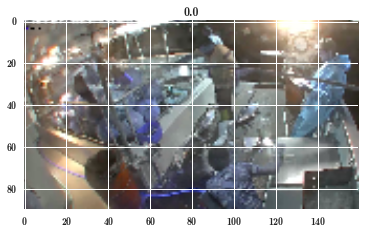

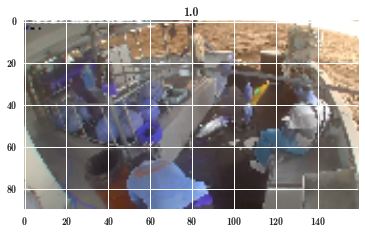

In [47]:
## Uncomment to check out a fish from each class
uniq = np.unique(y_all, return_index=True)
for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

In [52]:
submission = pd.DataFrame(test_preds, columns=FISH_CLASSES)
submission.insert(0, 'image', test_files)
submission.head(10)

,image,ALB,BET,DOL,LAG,Nof,OTHER,SHARK,YFT
0,img_06959.jpg,0.963790,5.943310e-07,2.105724e-08,3.771714e-08,1.156391e-03,8.867893e-07,9.298041e-10,0.000000
1,img_00582.jpg,0.979436,4.483646e-07,7.380279e-08,7.156315e-07,4.777637e-05,1.031685e-05,2.456520e-09,0.000003
2,img_03760.jpg,0.928267,5.328111e-06,5.829607e-07,1.801630e-06,2.451130e-04,7.112842e-04,1.323719e-07,0.001176
3,img_05721.jpg,0.000000,5.074365e-10,2.286148e-07,1.501422e-14,1.822497e-09,2.084570e-10,2.055220e-11,0.990492
4,img_04156.jpg,0.414800,2.194591e-05,1.159669e-07,7.214410e-07,1.546979e-05,4.651932e-03,5.841277e-08,0.000538
5,img_06373.jpg,0.000001,6.431042e-09,2.409974e-07,2.109002e-13,3.060730e-09,2.421435e-09,5.427255e-10,0.993941
6,img_04024.jpg,0.827182,1.386210e-09,7.320739e-11,1.642065e-11,3.421547e-08,8.824404e-07,1.974378e-12,0.001773
7,img_04037.jpg,0.960498,9.201428e-07,3.369053e-08,1.763097e-07,3.133942e-05,4.589394e-04,3.416055e-09,0.000015
8,img_01773.jpg,0.039052,3.441589e-07,1.249050e-08,3.507724e-10,7.511759e-08,1.400082e-06,2.840042e-09,0.460410
9,img_05908.jpg,0.007481,6.574523e-05,4.847634e-05,2.128216e-06,4.503088e-01,7.150712e-06,6.953935e-06,0.018059


In [49]:
x = submission['image'].head(10)
test_files = x
TEST_all = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    TEST_all[i] = read_image(TEST_DIR+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(test_files)))

print(TEST_all.shape)

Processed 0 of 10
(10, 90, 160, 3)


In [50]:
TEST_all = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    TEST_all[i] = read_image(TEST_DIR+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(test_files)))

print(TEST_all.shape)

Processed 0 of 10
(10, 90, 160, 3)


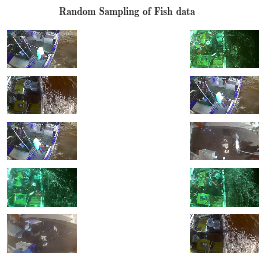

In [51]:
%matplotlib inline
import struct
from numpy import *
from matplotlib.pyplot import *

# Get the figure and axes.
fig, axes = subplots(5, 2)
axes = axes.reshape(10)
fig.suptitle("Random Sampling of Fish data")

# Plot random images.
indices = random.randint(len(TEST_all), size=10)
for axis, index in zip(axes, indices):
    image = TEST_all[index, :, :]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.imshow(image,cmap = cm.Greys_r)